In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aftabhussaincui/refined-rnsa-ct-scans-12k-pngs
! unzip refined-rnsa-ct-scans-12k-pngs.zip

In [ ]:
!pip install vit_keras
! pip install tensorflow_addons

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout, SpatialDropout2D ,BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os, random, shutil

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import backend, optimizers
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler



In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

def allocate_gpu_memory(gpu_number=0):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')

    if physical_devices:
        try:
            print("Found {} GPU(s)".format(len(physical_devices)))
            tf.config.set_visible_devices(physical_devices[gpu_number], 'GPU')
            tf.config.experimental.set_memory_growth(physical_devices[gpu_number], True)
            print("#{} GPU memory is allocated".format(gpu_number))
        except RuntimeError as e:
            print(e)
    else:
        print("Not enough GPU hardware devices available")
allocate_gpu_memory()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Found 1 GPU(s)
#0 GPU memory is allocated


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12676846073755432393
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 261414374429751503
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [8]:
dataset_path = 'RNSA_Subset_PNGs_12K'

In [9]:
! rm 'RNSA_Subset_PNGs_12K/Meta data.txt'

In [10]:
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path)]

# Initialize empty lists to store the file paths for each set
train_set, validation_set, test_set = [], [], []

# Loop over each folder and split the PNG images into sets
for folder in folders:
    # Get the folder name (label)
    folder_name = os.path.basename(folder)
    # Get a list of all the PNG images in the folder
    png_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')]
    random.shuffle(png_images)
    # Define the percentage split for train, validation, and test sets
    train_percent, validation_percent, test_percent = 0.75, 0.15, 0.1
    # Split the PNG images into train, validation, and test sets
    num_files = len(png_images)
    train_end = int(num_files * train_percent)
    validation_end = int(num_files * (train_percent + validation_percent))
    train_set += png_images[:train_end]
    validation_set += png_images[train_end:validation_end]
    test_set += png_images[validation_end:]

In [11]:
for directory in ['Train', 'Validation', 'Test']:
    os.makedirs(os.path.join(dataset_path, directory), exist_ok=True)


# Loop over the train, validation, and test sets, and copy each image to the appropriate directory
for set_name, set_files in [('Train', train_set), ('Validation', validation_set), ('Test', test_set)]:
    for folder_name in ['Normal', 'Epidural_Positive','Intraventricular_Positive', 'Subdural_Positive', 'Intraparenchymal_Positvie', 'Subarachnoid_Positive', 'Any_Positive']:
        # Create the folder in the set directory
        os.makedirs(os.path.join(dataset_path, set_name, folder_name), exist_ok=True)
        # Get the images in the current folder
        folder_files = [f for f in set_files if folder_name in f]
        # Copy the images to the set directory
        for f in folder_files:
            dest_folder = os.path.join(dataset_path, set_name, folder_name)
            shutil.copy(f, dest_folder)

# Print the number of images in each set
print("Train set size:", len(train_set))
print("Validation set size:", len(validation_set))
print("Test set size:", len(test_set))

Train set size: 9000
Validation set size: 1800
Test set size: 1200


Found 6004 images belonging to 7 classes.
Found 1591 images belonging to 7 classes.


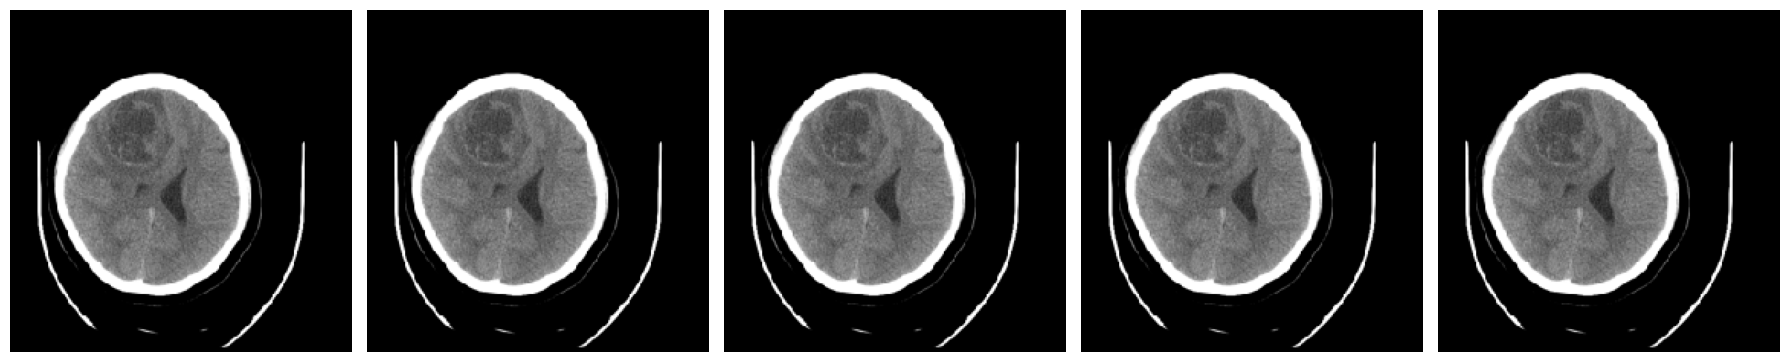

In [12]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,
    # vertical_flip=True,
    # zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Train",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_generator = test_datagen.flow_from_directory(
    "RNSA_Subset_PNGs_12K/Validation",
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical'
)

# test_generator = test_datagen.flow_from_directory(
#     os.path.join(
#         'dataset',
#         'test'
#     ),
#     target_size=(256, 256),
#     color_mode='rgb',
#     class_mode=None
# )

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(18,18))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)


In [13]:
import tensorflow_addons
from vit_keras import vit

backend.clear_session()

vit_model = vit.vit_l32(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

print(len(vit_model.layers))
print(vit_model.layers)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


1226658854/1226658854 [==============================] - 9s 0us/step


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


31
[<keras.engine.input_layer.InputLayer object at 0x7fdd3837c280>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdc12acbf10>, <keras.layers.reshaping.reshape.Reshape object at 0x7fdc2025c610>, <vit_keras.layers.ClassToken object at 0x7fdc2025cbe0>, <vit_keras.layers.AddPositionEmbs object at 0x7fdc12b29be0>, <vit_keras.layers.TransformerBlock object at 0x7fdc12adddf0>, <vit_keras.layers.TransformerBlock object at 0x7fdc12add940>, <vit_keras.layers.TransformerBlock object at 0x7fdbec7cd940>, <vit_keras.layers.TransformerBlock object at 0x7fdbec768490>, <vit_keras.layers.TransformerBlock object at 0x7fdbec6d0f40>, <vit_keras.layers.TransformerBlock object at 0x7fdbec79dc40>, <vit_keras.layers.TransformerBlock object at 0x7fdbec6dcc40>, <vit_keras.layers.TransformerBlock object at 0x7fdbec653c70>, <vit_keras.layers.TransformerBlock object at 0x7fdbec63df10>, <vit_keras.layers.TransformerBlock object at 0x7fdbec636e50>, <vit_keras.layers.TransformerBlock object at 0x7fdbec557730

In [14]:
def scheduler(epoch: int, lr: float) -> float:
    if epoch != 0 and epoch % 7 == 0:
        return lr * 0.1
    else:
        return lr
METRICS = [tf.keras.metrics.AUC(name='acc')]
lr_scheduler_callback = LearningRateScheduler(scheduler)




In [15]:
finetune_at = 28

# fine-tuning
for layer in vit_model.layers[:finetune_at - 1]:
    layer.trainable = False
    
num_classes = len(valid_generator.class_indices)

# Add GaussianNoise layer for robustness
noise = GaussianNoise(0.01, input_shape=(224, 224, 3))
# Classification head
head = Dense(num_classes, activation="softmax")

model = Sequential()
model.add(noise)
model.add(vit_model)
model.add(head)



In [16]:
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [17]:
history = model.fit(
          train_generator,
          epochs=30,
          validation_data=valid_generator,
          verbose=1, 
          shuffle=True,
          callbacks=[
              EarlyStopping(monitor="val_acc", patience=10, restore_best_weights=True),
              lr_scheduler_callback,
          ])

Epoch 1/30
188/188 [==============================] - 157s 630ms/step - loss: 1.7923 - acc: 0.6808 - val_loss: 1.4679 - val_acc: 0.8023 - lr: 0.0010
Epoch 2/30
188/188 [==============================] - 103s 548ms/step - loss: 1.6443 - acc: 0.7401 - val_loss: 1.3646 - val_acc: 0.8308 - lr: 0.0010
Epoch 3/30
188/188 [==============================] - 102s 540ms/step - loss: 1.5916 - acc: 0.7592 - val_loss: 1.3614 - val_acc: 0.8304 - lr: 0.0010
Epoch 4/30
188/188 [==============================] - 102s 543ms/step - loss: 1.5783 - acc: 0.7634 - val_loss: 1.4004 - val_acc: 0.8221 - lr: 0.0010
Epoch 5/30
188/188 [==============================] - 102s 545ms/step - loss: 1.5316 - acc: 0.7818 - val_loss: 1.3459 - val_acc: 0.8357 - lr: 0.0010
Epoch 6/30
188/188 [==============================] - 103s 546ms/step - loss: 1.5125 - acc: 0.7884 - val_loss: 1.3011 - val_acc: 0.8466 - lr: 0.0010
Epoch 7/30
188/188 [==============================] - 102s 541ms/step - loss: 1.4764 - acc: 0.8009 - val_l

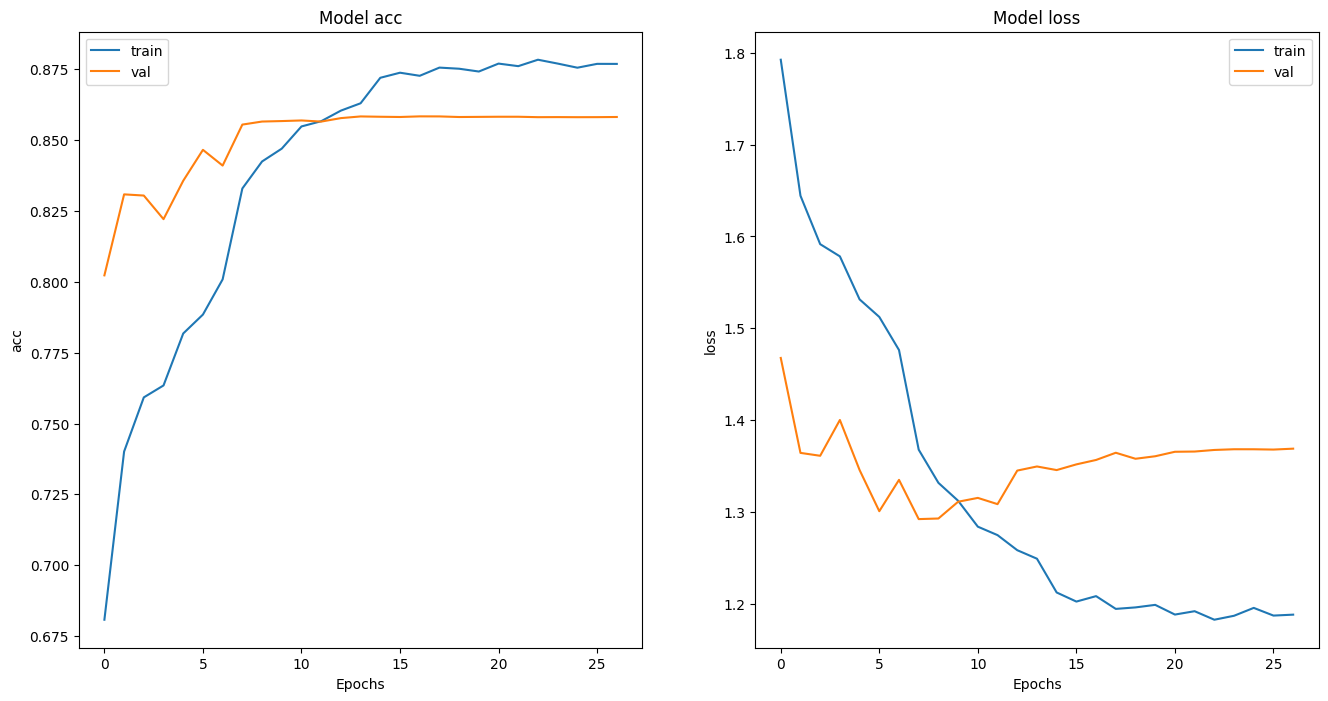

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [20]:
def predict(img_rel_path):
    # Import Image from the path with size of (224, 224)
    img = image.load_img(img_rel_path, target_size=(224, 224))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])
    # Label array
    labels = {0: 'Any', 1: 'Epidural', 2: 'Intraparenchymal', 3: 'Intraventricular', 4: 'normal', 5: 'Subarachnoid',
              6: 'Subdural'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("pred:", predicted_class)
    print("correct :"+str(img_rel_path).split("/")[1], "\n\n")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

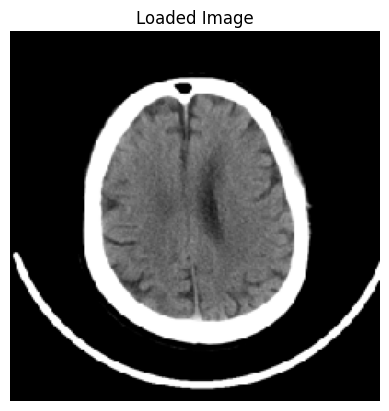

1/1 [==============================] - 6s 6s/step


Maximum Probability:  0.95631903
pred: normal
correct :Epidural_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.61 %
EPIDURAL : 0.76 %
INTRAPARENCHYMAL : 0.12 %
INTRAVENTRICULAR : 0.02 %
NORMAL : 95.63 %
SUBARACHNOID : 0.39 %
SUBDURAL : 2.47 %


In [21]:
predict(test_set[583])

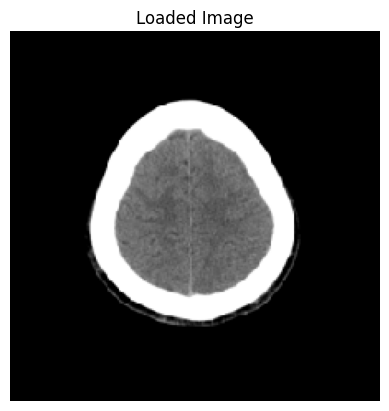

1/1 [==============================] - 0s 89ms/step


Maximum Probability:  0.43254495
pred: normal
correct :Any_Normal 



-------------------Individual Probability--------------------------------

ANY : 2.56 %
EPIDURAL : 15.16 %
INTRAPARENCHYMAL : 0.33 %
INTRAVENTRICULAR : 0.02 %
NORMAL : 43.25 %
SUBARACHNOID : 27.66 %
SUBDURAL : 11.02 %


In [22]:
predict(test_set[683])

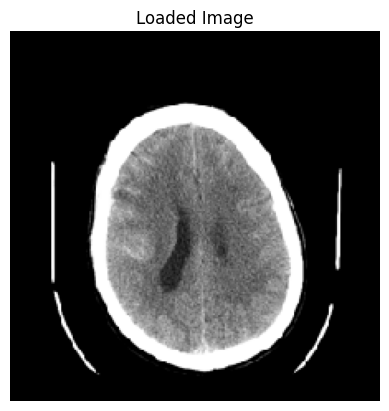

1/1 [==============================] - 0s 116ms/step


Maximum Probability:  0.33556354
pred: Subarachnoid
correct :Subarachnoid_Positive 



-------------------Individual Probability--------------------------------

ANY : 15.9 %
EPIDURAL : 0.71 %
INTRAPARENCHYMAL : 27.21 %
INTRAVENTRICULAR : 7.29 %
NORMAL : 7.38 %
SUBARACHNOID : 33.56 %
SUBDURAL : 7.96 %


In [58]:
predict(test_set[323])

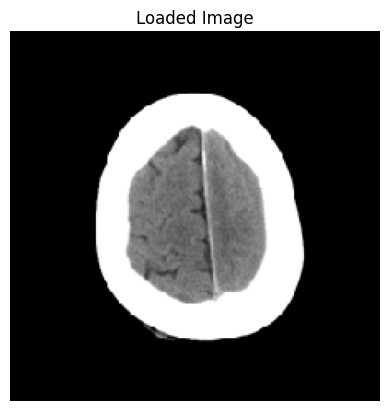

1/1 [==============================] - 0s 77ms/step


Maximum Probability:  0.46821064
pred: normal
correct :Intraparenchymal_Normal 



-------------------Individual Probability--------------------------------

ANY : 4.21 %
EPIDURAL : 3.78 %
INTRAPARENCHYMAL : 1.14 %
INTRAVENTRICULAR : 0.03 %
NORMAL : 46.82 %
SUBARACHNOID : 28.5 %
SUBDURAL : 15.52 %


In [24]:
predict(test_set[983])

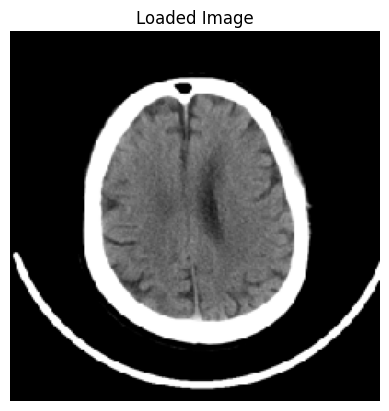

1/1 [==============================] - 0s 86ms/step


Maximum Probability:  0.95631903
pred: normal
correct :Epidural_Normal 



-------------------Individual Probability--------------------------------

ANY : 0.61 %
EPIDURAL : 0.76 %
INTRAPARENCHYMAL : 0.12 %
INTRAVENTRICULAR : 0.02 %
NORMAL : 95.63 %
SUBARACHNOID : 0.39 %
SUBDURAL : 2.47 %


In [25]:
predict(test_set[583])

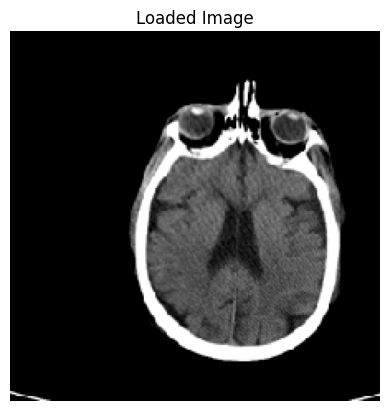

1/1 [==============================] - 0s 84ms/step


Maximum Probability:  0.77743244
pred: normal
correct :Intraventricular_Normal 



-------------------Individual Probability--------------------------------

ANY : 5.51 %
EPIDURAL : 2.68 %
INTRAPARENCHYMAL : 0.5 %
INTRAVENTRICULAR : 0.03 %
NORMAL : 77.74 %
SUBARACHNOID : 3.72 %
SUBDURAL : 9.81 %


In [50]:
predict(test_set[473])

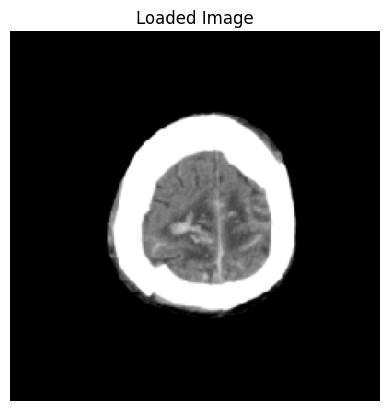

1/1 [==============================] - 0s 105ms/step


Maximum Probability:  0.52498007
pred: Subarachnoid
correct :Subarachnoid_Positive 



-------------------Individual Probability--------------------------------

ANY : 4.49 %
EPIDURAL : 0.23 %
INTRAPARENCHYMAL : 10.85 %
INTRAVENTRICULAR : 0.03 %
NORMAL : 15.85 %
SUBARACHNOID : 52.5 %
SUBDURAL : 16.05 %


In [27]:
predict(test_set[383])

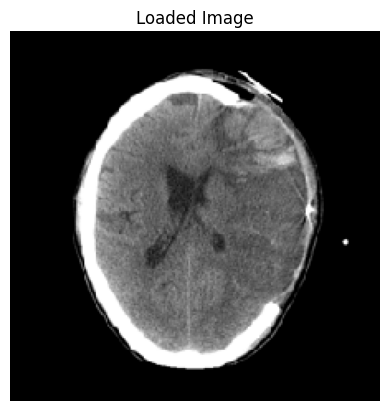

1/1 [==============================] - 0s 79ms/step


Maximum Probability:  0.777168
pred: Epidural
correct :Epidural_Positive 



-------------------Individual Probability--------------------------------

ANY : 3.86 %
EPIDURAL : 77.72 %
INTRAPARENCHYMAL : 5.24 %
INTRAVENTRICULAR : 2.51 %
NORMAL : 0.24 %
SUBARACHNOID : 4.6 %
SUBDURAL : 5.83 %


In [47]:
predict(test_set[223])